In [13]:
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K

import multiprocessing
from multiprocessing import Pool
from functools import partial
%matplotlib inline

def clear_line():
    print(' '*80,end='\r')
    
#function to get activation of input data into a list
def get_activation(data, get_layer_output_functions): 
    layer_output = []
    for f in get_layer_output_functions[:-1]:
        layer_output.append(f(data.reshape(1,2))[0])

    for i in range(len(layer_output)):
        #layer_nonzero_index = np.flatnonzero(layer_output[i])
        layer_output[i][np.flatnonzero(layer_output[i])] = 1
        layer_output[i] = layer_output[i].astype(int)
        
    act_list = layer_output
    return act_list

#assign a different color to each different activation,use color index
def assign_color(activations,act_index):
    color_index = 0
    for i in range(len(activations[0])):
        binary = ''.join(str(e) for e in activations[act_index][i].astype(int))
        color_index+=int(binary,2)
    return color_index

def prepare_model(hid_layer_units):
    model = tf.keras.Sequential()
    for i in range(len(hid_layer_units)):
        if i == 0:
            model.add(Dense(hid_layer_units[i], input_shape=(2,), activation='relu',bias_initializer='random_uniform'))
        else:
            model.add(Dense(hid_layer_units[i], activation='relu',bias_initializer='random_uniform'))
    model.add(Dense(2, activation='softmax',bias_initializer='random_uniform'))
    # Configure a model for categorical classification.
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=[tf.keras.metrics.categorical_accuracy])
    return model

def data_grid(grid, square_len):
    k = square_len
    x = np.linspace(-k,k,grid+1)
    y = np.linspace(-k,k,grid+1) 

    xv,yv = np.meshgrid( x , y )
    data = np.array([xv.flatten(),yv.flatten()])
    data = data.transpose()
    return data

def get_color(data):
    interval = int(np.ceil(255/len(data)**(1/3.0)))
    R = range(0,255,interval)
    G = range(0,255,interval)
    B = range(0,255,interval)
    rv,gv,bv = np.meshgrid(R,G,B)
    colors = np.array([rv.flatten(),gv.flatten(),bv.flatten()]).transpose()
    np.random.shuffle(colors)
    return colors

def get_data_activation(all_data, get_layer_output_functions):
    #loop for all data points to get activations
    i_data = 0
    activations = []

    for data in all_data:
        #act_progress = "get activation progress:{0}%".format(round((i_data + 1) * 100 / len(X_test)))
        #print(act_progress, end='\r')
        activations.append(get_activation(data,get_layer_output_functions))
        i_data = i_data + 1
        
    return activations

def get_data_color(activations,colors):
    f = partial(assign_color,activations)
    i_color=0
    data_activation_color=[]
    pool = Pool(8)
    
    for y in pool.map(f, range(len(activations))):
        i_color+=1
        #color_progress = "get data color progress:{0}% ".format(round((i_color + 1) * 100 / len(activations)))
        #print(color_progress, end='\r')
        data_activation_color.append(y)

    data_activation_color = np.asarray(data_activation_color)
    data_color_cluster = np.unique(data_activation_color)
    for color_i in range(len(data_activation_color)):
        [data_activation_color[color_i]] = np.where(data_color_cluster == data_activation_color[color_i])[0]
    data_activation_color = data_activation_color.astype(int)
    data_activation_color = colors[data_activation_color]/255
    pool.close()
    pool.join()
    
    return data_activation_color

def get_activation_prediction_transition(num_epoch, colors, X_test, model):    
    get_layer_output_functions = []
    for layer_i in range(len(model.layers)):
        get_layer_output_functions.append(K.function(model.layers[0].input,model.layers[layer_i].output))

    for epoch_i in range(num_epoch):        
        activations = get_data_activation(X_test, get_layer_output_functions)
        data_activation_color = get_data_color(activations,colors)
        Y_test = model.predict(X_test)

        np.savez_compressed(directory+'/'+'epoch'+str(format(epoch_i,'0>3'))+'_model_'+model_name,\
                                                        data_activation_color=data_activation_color,\
                                                                 activations = activations,\
                                                                prediction = Y_test)

        step = epoch_i+1
        history = model.fit(data, labels, epochs=1,verbose=0,steps_per_epoch=step,batch_size=batch_size)
        train_info = 'epoch '+ str(epoch_i+1)+': '+str(history.history)
        print(train_info, end='\n')

        File = open(trainlog_path+'/'+model_name+'.txt','a+') 
        File.write(train_info+'\n')
        File.flush()
        File.close()  
        


## Prepare Data

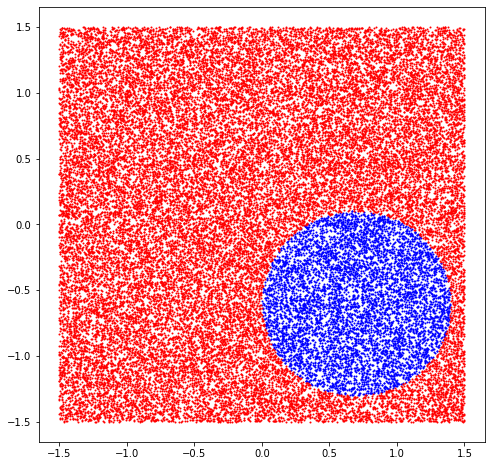

In [14]:
#Prepare data
N=40000
L=3
X = L*np.random.rand(N,2) 
X[:,0] = X[:,0]-L/2
X[:,1] = X[:,1]-L/2

Y = np.zeros([N,2])

for i in range(N):
    if (X[i,0]-0.7)**2+(X[i,1]+0.6)**2<0.49:
        Y[i,0]=1
    else:
        Y[i,1]=1

zero_class = np.where(Y[:, 0])
one_class = np.where(Y[:, 1])

plt.figure(figsize=(8, 8))
plt.scatter(X[zero_class, 0], X[zero_class, 1], s=1, facecolors='b', linewidths=1, label='Class 1')
plt.scatter(X[one_class, 0], X[one_class, 1], s=1, facecolors='r', linewidths=1, label='Class 2')
plt.show()

data = X
labels = Y

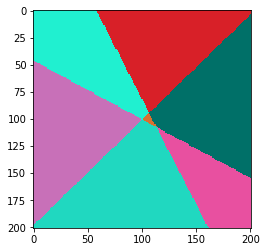

In [17]:
a=np.load('iterasive_result/model_3_2/epoch000_model_3_2.npz')
a['activations']
plt.imshow(a['data_activation_color'].reshape(201,201,3))

In [15]:
import os

first_layer = [3,10,20,30,60,90]
#second_layer = [30,60,90]

num_epoch = 100
X_test = data_grid(grid=200,square_len=2)
batch_size = 32
colors = get_color(X_test)

for i in range(len(first_layer)):
#     for j in range(len(second_layer)):
#         print('hid_layer: [%i , %i]'%(first_layer[i],second_layer[j]))
#         print('progress :', (i+j)/(len(first_layer)+len(second_layer)))
#         hid_layer_units = [first_layer[i], second_layer[j]]
    print('hid_layer: [%i]'%(first_layer[i]))
    print('progress :', i/(len(first_layer)))
    hid_layer_units = [first_layer[i]]
    model = prepare_model(hid_layer_units)

    model_name = '_'.join(str(e) for e in hid_layer_units)+'_2'
    directory = 'iterasive_result/'+'model_'+model_name
    if not os.path.exists(directory):
        os.makedirs(directory)

    trainlog_path = 'iterasive_result/trainlog'
    if not os.path.exists(trainlog_path):
        os.makedirs(trainlog_path)

    get_activation_prediction_transition(num_epoch,colors,X_test,model)

hid_layer: [3]
progress : 0.0
epoch 1: {'loss': [0.5418453216552734], 'categorical_accuracy': [0.721225]}
epoch 2: {'loss': [0.5401929616928101], 'categorical_accuracy': [0.72205]}
epoch 5: {'loss': [0.528878128528595], 'categorical_accuracy': [0.728305]}
epoch 6: {'loss': [0.5231370329856873], 'categorical_accuracy': [0.73127085]}
epoch 7: {'loss': [0.5165293387004307], 'categorical_accuracy': [0.73464286]}
epoch 8: {'loss': [0.5091526061296463], 'categorical_accuracy': [0.73854065]}
epoch 9: {'loss': [0.5011167228221893], 'categorical_accuracy': [0.7426889]}
epoch 10: {'loss': [0.492530819773674], 'categorical_accuracy': [0.79499]}
epoch 11: {'loss': [0.4835037345235998], 'categorical_accuracy': [0.8277]}
epoch 12: {'loss': [0.47415660073359805], 'categorical_accuracy': [0.8277]}
epoch 13: {'loss': [0.46459678503183216], 'categorical_accuracy': [0.8277]}
epoch 14: {'loss': [0.4549228144543512], 'categorical_accuracy': [0.8277]}
epoch 15: {'loss': [0.44522546927134193], 'categorical_a

epoch 8: {'loss': [0.5696192607283592], 'categorical_accuracy': [0.8277]}
epoch 9: {'loss': [0.5509341756502787], 'categorical_accuracy': [0.8277]}
epoch 10: {'loss': [0.5306297779083252], 'categorical_accuracy': [0.8277]}
epoch 11: {'loss': [0.5089473101225767], 'categorical_accuracy': [0.8277]}
epoch 12: {'loss': [0.4862187181909879], 'categorical_accuracy': [0.8277]}
epoch 13: {'loss': [0.46289024444726795], 'categorical_accuracy': [0.8277]}
epoch 14: {'loss': [0.43947806102888926], 'categorical_accuracy': [0.8277]}
epoch 15: {'loss': [0.4164873023827871], 'categorical_accuracy': [0.8277]}
epoch 16: {'loss': [0.39429610036313534], 'categorical_accuracy': [0.8277]}
epoch 17: {'loss': [0.37314362911617055], 'categorical_accuracy': [0.8277]}
epoch 18: {'loss': [0.35319056775834823], 'categorical_accuracy': [0.8277]}
epoch 19: {'loss': [0.3345681789674257], 'categorical_accuracy': [0.8277]}
epoch 20: {'loss': [0.3173932686448097], 'categorical_accuracy': [0.8277]}
epoch 21: {'loss': [0.

epoch 14: {'loss': [0.4341807897601809], 'categorical_accuracy': [0.8277]}
epoch 15: {'loss': [0.4087866226832072], 'categorical_accuracy': [0.8277]}
epoch 16: {'loss': [0.38456803001463413], 'categorical_accuracy': [0.8277]}
epoch 17: {'loss': [0.361959555569817], 'categorical_accuracy': [0.8277]}
epoch 18: {'loss': [0.34134061800109017], 'categorical_accuracy': [0.81785834]}
epoch 19: {'loss': [0.32296486277329295], 'categorical_accuracy': [0.80952895]}
epoch 20: {'loss': [0.30691716372966765], 'categorical_accuracy': [0.8217125]}
epoch 21: {'loss': [0.2930802929969061], 'categorical_accuracy': [0.83204764]}
epoch 22: {'loss': [0.2811221033334732], 'categorical_accuracy': [0.8411159]}
epoch 23: {'loss': [0.2706662831099137], 'categorical_accuracy': [0.849637]}
epoch 24: {'loss': [0.2613701435426871], 'categorical_accuracy': [0.8571594]}
epoch 25: {'loss': [0.25272592723369597], 'categorical_accuracy': [0.865708]}
epoch 26: {'loss': [0.2447625994682312], 'categorical_accuracy': [0.872

epoch 18: {'loss': [0.3429873122109307], 'categorical_accuracy': [0.8062264]}
epoch 19: {'loss': [0.32471018559054327], 'categorical_accuracy': [0.8140829]}
epoch 20: {'loss': [0.30873813927173616], 'categorical_accuracy': [0.82438374]}
epoch 21: {'loss': [0.2948319060461862], 'categorical_accuracy': [0.8328107]}
epoch 22: {'loss': [0.2827967825261029], 'categorical_accuracy': [0.84063977]}
epoch 23: {'loss': [0.27238805915998376], 'categorical_accuracy': [0.8466272]}
epoch 24: {'loss': [0.26330186799168587], 'categorical_accuracy': [0.85221356]}
epoch 25: {'loss': [0.255243262052536], 'categorical_accuracy': [0.856639]}
epoch 26: {'loss': [0.24802594975783274], 'categorical_accuracy': [0.86222214]}
epoch 27: {'loss': [0.24147625929779476], 'categorical_accuracy': [0.8673074]}
epoch 28: {'loss': [0.23544737483773912], 'categorical_accuracy': [0.87205625]}
epoch 29: {'loss': [0.22979522779070097], 'categorical_accuracy': [0.8759638]}
epoch 30: {'loss': [0.22435626188913982], 'categorica

epoch 22: {'loss': [0.22163085707209326], 'categorical_accuracy': [0.8870909]}
epoch 23: {'loss': [0.21480653985686923], 'categorical_accuracy': [0.8929565]}
epoch 24: {'loss': [0.2079068881769975], 'categorical_accuracy': [0.89818126]}
epoch 25: {'loss': [0.20077883958816528], 'categorical_accuracy': [0.903644]}
epoch 26: {'loss': [0.19333628794321647], 'categorical_accuracy': [0.9092731]}
epoch 27: {'loss': [0.18555572242648513], 'categorical_accuracy': [0.91460186]}
epoch 28: {'loss': [0.17747877591422626], 'categorical_accuracy': [0.92070895]}
epoch 29: {'loss': [0.16919911061895304], 'categorical_accuracy': [0.9305069]}
epoch 30: {'loss': [0.1608408768971761], 'categorical_accuracy': [0.941725]}
epoch 31: {'loss': [0.15253011065144692], 'categorical_accuracy': [0.9511992]}
epoch 32: {'loss': [0.14440092956647277], 'categorical_accuracy': [0.9591133]}
epoch 33: {'loss': [0.13656726840770606], 'categorical_accuracy': [0.9656068]}
epoch 34: {'loss': [0.12910558721598456], 'categorica

IndexError: arrays used as indices must be of integer (or boolean) type

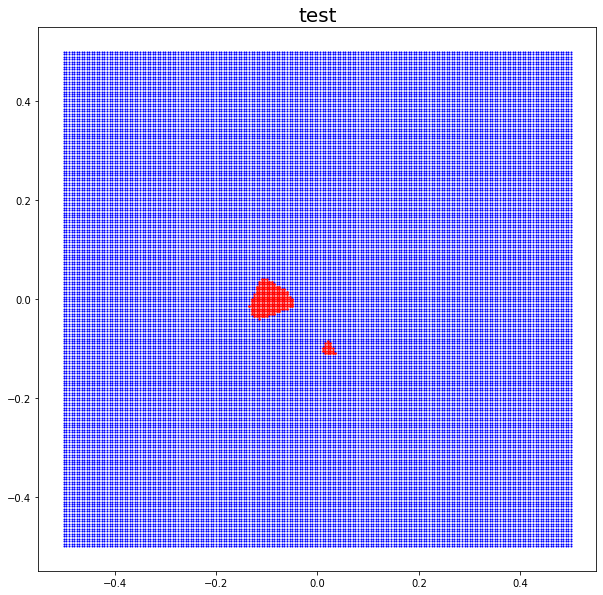

In [4]:
#test
import numpy as np

X_test = data_grid(200,0.5)
#np.random.shuffle(X_test)

Y_test = model.predict(X_test)
Y_test = np.rint(Y_test)

zero_class_test = np.where(Y_test[:, 0])
one_class_test = np.where(Y_test[:, 1])

plt.figure(figsize=(10, 10))
plt.scatter(X_test[zero_class_test, 0], X_test[zero_class_test, 1], marker='o',s=3, facecolors='r', linewidths=1, label='Class 1')
plt.scatter(X_test[one_class_test, 0], X_test[one_class_test, 1], marker='o', s=1, facecolors='b', linewidths=1, label='Class 2')
plt.title('test',fontsize=20)
plt.show()
plt.close()

In [12]:
model = prepare_model([10])
model.fit(data, labels, epochs=10,steps_per_epoch=0,batch_size=32)

from tensorflow.keras import backend as K

get_layer_output_functions = []
for layer_i in range(len(model.layers)):
    get_layer_output_functions.append(K.function(model.layers[0].input,model.layers[layer_i].output))

colors = get_color(X_test)
activations = get_data_activation(X_test,get_layer_output_functions)
data_activation_color = get_data_color(activations,colors)

plt.figure(figsize=(10, 10))
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o',s=4, c=data_activation_color, linewidths=2,cmap = 'gray')
plt.show()
plt.close()

ValueError: If steps_per_epoch is set, the `batch_size` must be None.

In [ ]:
import time
for x in range(10000):
    print('x = ',x,end='\r')
    time.sleep(0.01)